In [1]:
%load_ext tensorboard

Multitask algorithm

The multitask algorithm  takes as inputs 2 different images of cars and simultaneously performs 2 tasks :

- Predict whether the 2 cars are of the same model
- Output 1 bounding box per image representing the location of the car 







Please explain your approach in detail.

* Architecture:
  * The approach is to use a pretrained model and update the last layer according to our requirement.
  * We'll keep the base model as ResNet and send the output of this base model to two layers: 1 being the classifier and the other being the regressor.
  * The CNN model (Resnet) will act as backbone for both the classifier and regressor heads.
  * We won't use both the images in the dataset simultaneously, instead will train model to predict car model efficiently and then compare the output.
  * For the heads the classifier will use softmax activation function and sigmoid will be used by regressor.
  * The classifier will have 196 outputs (corresponding to each class) and the regressor will have 4 output for the 4 coordinates of the bounding box.
  * We'll select the class with highest probability as the final label from the model.
  * We'll use 'sparse_categorical_crossentropy' and 'mean_squared_error' as our loss functions respectively.
  * We'll fine tune the some of the layers of the model, to improve performance on our dataset
* Dataset:
  * We'll normalize the bounding box coordinates for better performance.
  * We'll preprocess image to shrink it to size 224*224 and convert it to be used with Resnet.

In [2]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import datetime
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
train_df = pd.read_csv('../data/train_dataset_fixed.csv')
valid_df = pd.read_csv('../data/validation_dataset_fixed.csv')

In [5]:
train_df.head()

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,split
0,car_ims/000078.jpg,25,123,589,421,1,train
1,car_ims/000024.jpg,3,23,132,98,1,train
2,car_ims/000031.jpg,125,645,1845,1421,1,train
3,car_ims/000021.jpg,50,127,587,396,1,train
4,car_ims/000067.jpg,3,3,639,480,1,train


In [12]:
def normalize_bboxes(df):
    """
    Normalize the bounding boxes' coordinates of the dataframe
    """
    for index, row in df.iterrows():
        with Image.open(os.path.join('../data',row['relative_im_path'])) as img:
            width, height = img.size
        
        df.loc[index, 'x_min'] = row['bbox_x1'] / width
        df.loc[index, 'y_min'] = row['bbox_y1'] / height
        df.loc[index, 'x_max'] = row['bbox_x2'] / width
        df.loc[index, 'y_max'] = row['bbox_y2'] / height

    return df

train_df_norm = normalize_bboxes(train_df)
valid_df_norm = normalize_bboxes(valid_df)


In [13]:
train_df_norm.head()

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,split,x_min,y_min,x_max,y_max
0,car_ims/000078.jpg,25,123,589,421,1,train,0.039062,0.256250,0.920312,0.877083
1,car_ims/000024.jpg,3,23,132,98,1,train,0.021898,0.223301,0.963504,0.951456
2,car_ims/000031.jpg,125,645,1845,1421,1,train,0.051975,0.403125,0.767152,0.888125
3,car_ims/000021.jpg,50,127,587,396,1,train,0.078125,0.264583,0.917188,0.825000
4,car_ims/000067.jpg,3,3,639,480,1,train,0.004687,0.006250,0.998437,1.000000


In [15]:
def preprocess_image(image_path, target_size=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return image

def load_and_preprocess_data(df, target_size=(224, 224)):
    images = np.stack([preprocess_image(os.path.join('../data',path), target_size) for path in df['relative_im_path']])
    
    labels = df['class'].values
    bboxes = np.stack([bbox for bbox in df[['x_min','y_min','x_max','y_max']].values])
    return images, [labels, bboxes]

train_images, train_labels = load_and_preprocess_data(train_df_norm)
val_images, val_labels=load_and_preprocess_data(valid_df_norm)


In [16]:
def create_multitask_model(num_classes):
    """
    Create a multi-task model based on ResNet50.
    The model has two outputs: one for classification and one for bounding box regression.
    
    """
    base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True
    
    fine_tune_at=160
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    classification_output = layers.Dense(num_classes, activation='softmax', name='model_classification')(x)

    bbox_output = layers.Dense(4, activation='sigmoid', name='bounding_box')(x)

    model = models.Model(inputs=base_model.input, outputs=[classification_output, bbox_output])

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
                  loss={'model_classification': 'sparse_categorical_crossentropy', 
                    'bounding_box': 'mean_squared_error'},
                metrics={'model_classification': 'accuracy', 
                            'bounding_box': 'mse'})

    return model

# pass the number of classes to the model
model = create_multitask_model(196)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [17]:
log_dir = "logs/multitask/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    train_images,
    {'model_classification': train_labels[0], 'bounding_box': train_labels[1]},
    validation_data=(val_images, {'model_classification': val_labels[0], 'bounding_box': val_labels[1]}),
    batch_size=32,
    epochs=10,
    callbacks=[tensorboard_callback]
)


Epoch 1/10


2024-05-16 15:07:19.532673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


402/402 [==============================] - 93s 219ms/step - loss: 5.3033 - model_classification_loss: 5.2932 - bounding_box_loss: 0.0101 - model_classification_accuracy: 0.0051 - bounding_box_mse: 0.0101 - val_loss: 6.9934 - val_model_classification_loss: 6.9705 - val_bounding_box_loss: 0.0230 - val_model_classification_accuracy: 0.0037 - val_bounding_box_mse: 0.0230
Epoch 2/10
402/402 [==============================] - 81s 202ms/step - loss: 5.2784 - model_classification_loss: 5.2704 - bounding_box_loss: 0.0080 - model_classification_accuracy: 0.0055 - bounding_box_mse: 0.0080 - val_loss: 7.1393 - val_model_classification_loss: 7.1163 - val_bounding_box_loss: 0.0229 - val_model_classification_accuracy: 0.0019 - val_bounding_box_mse: 0.0229
Epoch 3/10
402/402 [==============================] - 83s 208ms/step - loss: 5.2725 - model_classification_loss: 5.2645 - bounding_box_loss: 0.0080 - model_classification_accuracy: 0.0066 - bounding_box_mse: 0.0080 - val_loss: 7.1342 - val_model_cla

In [18]:
model.save('../model/multitask_model_resnet')

INFO:tensorflow:Assets written to: ../model/multitask_model_resnet/assets


INFO:tensorflow:Assets written to: ../model/multitask_model_resnet/assets


In [19]:
model=tf.keras.models.load_model('../model/multitask_model_resnet')

In [20]:
def prepare_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


In [21]:
def denormalize_box(box, img_size):
    x_min, y_min, x_max, y_max = box
    width, height = img_size
    x_min = int(x_min * width)
    x_max = int(x_max * width)
    y_min = int(y_min * height)
    y_max = int(y_max * height)
    return x_min, y_min, x_max, y_max


In [22]:
def plot_image_with_bbox(image_path, bbox):
    with Image.open(image_path) as img:
        plt.imshow(img)
        plt.axis('off')  

        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='g', facecolor='none')
        
        ax = plt.gca()
        ax.add_patch(rect)
        plt.show()

1/1 [==============================] - 0s 24ms/step


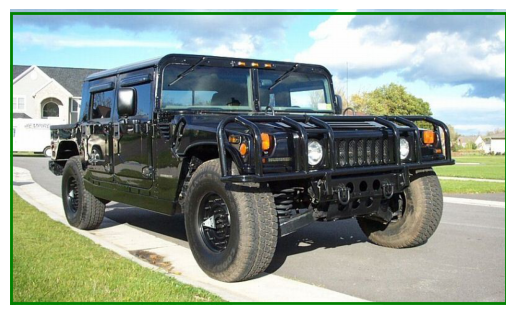

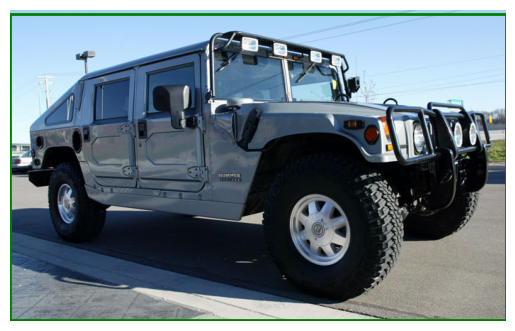

True
157 157


In [24]:
image_path_1 = '../data/car_ims/000081.jpg'
image_path_2 = '../data/car_ims/000020.jpg'

img_array = [prepare_image(image_path_1),prepare_image(image_path_2)]

predictions = [model.predict(img_array[0]),model.predict(img_array[1])]

predicted_class_1,predicted_bbox_1 = predictions[0][0][0], predictions[0][1][0]
predicted_class_2,predicted_bbox_2 = predictions[1][0][0], predictions[1][1][0]

img_1 = Image.open(image_path_1)
img_2 = Image.open(image_path_2)

bbox_1 = denormalize_box(predicted_bbox_1, img_1.size)
bbox_2 = denormalize_box(predicted_bbox_2, img_2.size)

# Display the image with the bounding box
plot_image_with_bbox(image_path_1, bbox_1)
plot_image_with_bbox(image_path_2, bbox_2)

print('True' if np.argmax(predicted_class_1) == np.argmax(predicted_class_2)else 'False')
print(np.argmax(predicted_class_1), np.argmax(predicted_class_2))